In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

import sys
from pathlib import Path

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, RandomRotation, RandomVerticalFlip, Resize, ToTensor

from sklearn.model_selection import train_test_split

In [2]:
#Check if device is running on GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [3]:
# Constructs a path to a directory that contains dataloader.py and plotCreator.py
module_path = str(Path.cwd().parents[0] / "methods")

# Checks to see if the directory is already in sys.path to avoid adding it multiple times.
if module_path not in sys.path:
    sys.path.append(module_path)

# Imports all the functions defined in the dataloader.py
from dataloader import *

In [4]:
# Creates two file paths pointing to two HDF5 files
data_path0 = str(Path.cwd().parents[0] / "data" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0] / "data" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

# Reads the two HDF5 data files and creates two NumPy arrays
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

# Combines the two arrays of data into a single array. It creates a combined dataset
# that can be used for training the machine learning model to distinguish 
# between the two classes.
dataArray = np.concatenate((bhArray, sphArray), axis=0)

# Creating an array of length 30,000 with the first 15,000 elements set to 0 and the
# second 15,000 elements set to 1. This corresponds to the two classes of data: black
# hole (class 0) and sphaleron (class 1).
labelsArray = np.concatenate((np.zeros(15_000),np.ones(15_000)),axis=0)

# Randomly splits the dataArray and labelsArray into two sets. The trainData and trainLabels
# will be used to train the machine learning model, while the testData and testLabels will be 
# used to evaluate the performance of the model. 
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

def random_shift_y(img, roll_axis):
    shift = torch.randint(low=0, high=list(img.shape)[roll_axis], size=(1, 1)).item()
    img = torch.roll(img, shift, roll_axis)
    return img

def augment_images(images):
    images = np.moveaxis(images, -1, 1)
    augmented_images = []
    for img in images:
        img = torch.from_numpy(img)
        
        img_flipped_horizontal = torch.flip(img, dims=[2]) #Mirror image of original, aka horizontal flipping on x axis
        img_flipped_vertical = random_shift_y(img, roll_axis=1) #displace top bottom on y axis
        img_rotated_180 = torch.rot90(img, 2, dims=[1, 2]) #Rotation 180 degrees

        augmented_images.extend(
            [img, img_flipped_horizontal, img_flipped_vertical, img_rotated_180]
        )
    return torch.stack(augmented_images)  # Use torch.stack instead of np.array

# Apply data augmentation only on the training set
augmented_trainData = augment_images(trainData)

# Repeat the labels for the training set to match the augmented dataset
trainLabels_repeated = np.repeat(trainLabels, 4)

# Convert the augmented training data and repeated labels to PyTorch tensors
trainLabels_repeated = torch.from_numpy(trainLabels_repeated)

# Create a TensorDataset from the augmented training data and repeated labels
train_augmented = torch.utils.data.TensorDataset(augmented_trainData, trainLabels_repeated)

# Create a DataLoader for the augmented training dataset with shuffle enabled and batch size of 50
trainLoader_augmented = DataLoader(train_augmented, shuffle=True, batch_size=50)

# Apply the same preprocessing step to the test set as the training set
testData_processed = np.moveaxis(testData, -1, 1)

# Create a TensorDataset for the test data
test = torch.utils.data.TensorDataset(torch.from_numpy(testData_processed), torch.from_numpy(testLabels))

# Create a DataLoader for the test data with shuffle and batch size
testLoader = DataLoader(test, shuffle=True, batch_size=50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

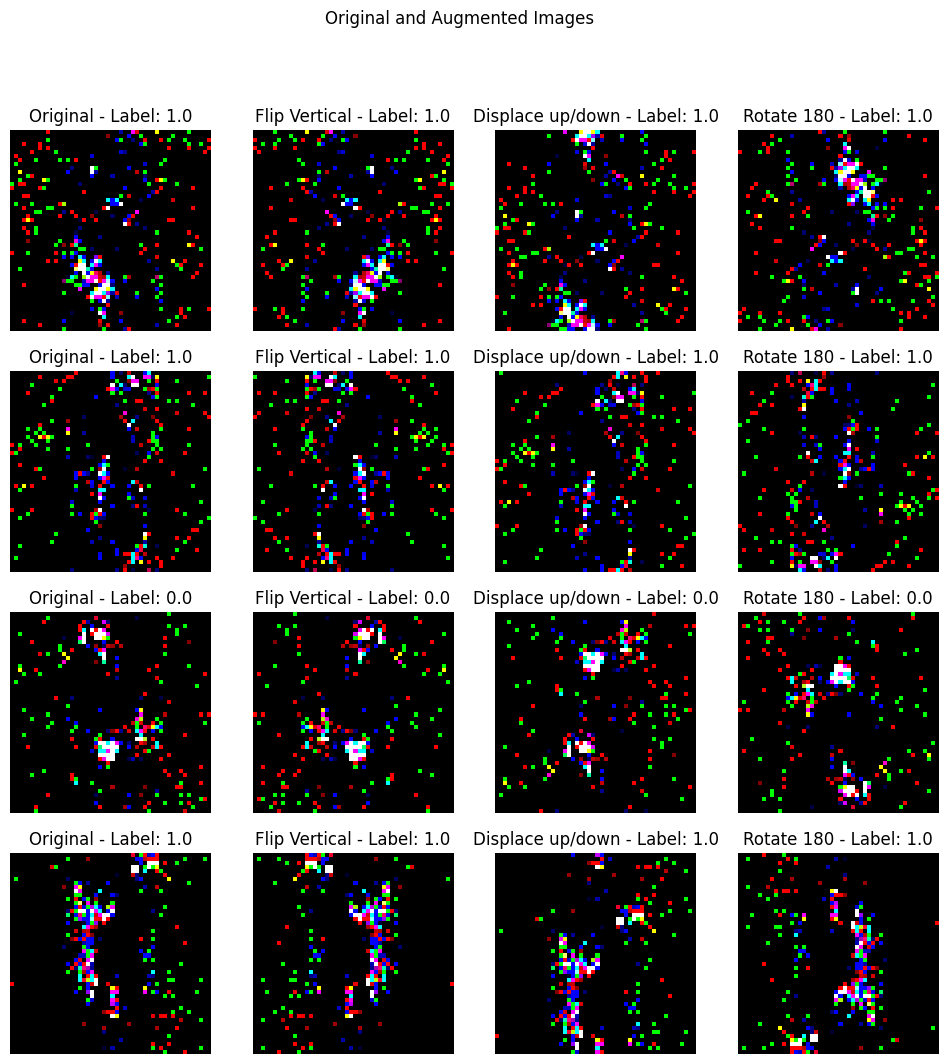

In [5]:
def visualize_comparison(original_images, augmented_images, labels, title, augmentation_info=None):
    n_images = len(original_images)
    n_columns = 4
    n_rows = n_images

    augmented_types = ['Original', 'Flip Vertical', 'Displace up/down', 'Rotate 180']

    fig, axs = plt.subplots(n_rows, n_columns, figsize=(3 * n_columns, 3 * n_rows))
    fig.suptitle(title)

    for i in range(n_images):
        for j in range(n_columns):
            if j == 0:
                img = original_images[i]
            else:
                img = augmented_images[4 * i + j]

            if isinstance(img, np.ndarray):
                img_rgb = np.moveaxis(img, 0, -1) if img.shape[0] == 3 else img
            elif isinstance(img, torch.Tensor):
                img_rgb = np.moveaxis(img.numpy(), 0, -1)

            ax = axs[i, j]
            ax.imshow(img_rgb)
            ax.set_title(f"{augmented_types[j]} - Label: {labels[i]}") #Change here for if label 1 is balck hole label 0 is sphaleron
            ax.axis('off')

    plt.show()

n_samples = 4
original_images = trainData[:n_samples]
original_labels = trainLabels[:n_samples]
augmented_images = augmented_trainData[:4 * n_samples]

visualize_comparison(original_images, augmented_images, original_labels, title="Original and Augmented Images")

In [6]:
import nnmodel

model = nnmodel.SymmetricNet2(0.5).to(device)  # Move the model to the appropriate device

# Print the model summary, make sure to provide appropriate input size (3, 50, 50) for the 3-channel 50x50 images
summary(model, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 48, 48]           3,584
       BatchNorm2d-2          [-1, 128, 48, 48]             256
            Conv2d-3          [-1, 128, 48, 48]           3,584
       BatchNorm2d-4          [-1, 128, 48, 48]             256
            Conv2d-5          [-1, 128, 48, 48]           3,584
       BatchNorm2d-6          [-1, 128, 48, 48]             256
 CircularAvgPool2d-7          [-1, 128, 25, 24]               0
 CircularAvgPool2d-8          [-1, 128, 25, 24]               0
 CircularAvgPool2d-9          [-1, 128, 25, 24]               0
          Dropout-10          [-1, 128, 25, 24]               0
           Conv2d-11          [-1, 256, 22, 21]         524,544
      BatchNorm2d-12          [-1, 256, 22, 21]             512
        AvgPool2d-13          [-1, 256, 11, 10]               0
          Dropout-14          [-1, 256,

In [7]:
import trainer2
import os
import pandas as pd

# Define the main function to run the experiment
def run_experiment(n_runs, model_class, model_args, optimizer_class, criterion_class, n_epochs, scheduler_class, scheduler_args):
    all_metrics = []  # List to store the metrics for all runs
    best_test_acc = -1.0  # Initialize the best_test_acc variable
    best_model = None  # Initialize the best_model variable

    # Loop through the number of runs specified
    for i in range(n_runs):
        print(f"Run {i+1}/{n_runs}")
        
        # Create the model using the given model class and arguments
        model = model_class(*model_args).to(device)

        # Set up the optimizer using the given optimizer class
        optimizer = optimizer_class(model.parameters())

        # Set up the criterion using the given criterion class
        criterion = criterion_class().to(device)
        
        # Create the learning rate scheduler using the given scheduler class and arguments
        scheduler = scheduler_class(optimizer, **scheduler_args)

        # Train the model using the trainer2.train function
        metrics = trainer2.train(model, trainLoader_augmented, testLoader, optimizer, criterion, n_epochs, scheduler)
        
        # Check if the current model has the best test accuracy and save it if it does
        current_best_acc = max(metrics['test_accs'])
        if current_best_acc > best_test_acc:
            best_test_acc = current_best_acc
            best_model = model  # Save the best model

        # Append the metrics for the current run to the list of all_metrics
        all_metrics.append(metrics)

    # Calculate the average metrics across all runs
    avg_metrics = {key: np.mean([m[key] for m in all_metrics], axis=0) for key in all_metrics[0].keys()}

    # Return the average metrics, all metrics, and the best model
    return avg_metrics, all_metrics, best_model

# Set the number of runs and training parameters
n_runs = 3
model_class = nnmodel.SymmetricNet2
model_args = (0.5,)
optimizer_class = torch.optim.Adam
criterion_class = nn.CrossEntropyLoss
n_epochs = 15
scheduler_class = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_args = {'patience': 3, 'verbose': True, 'factor': 0.5}

# Run the experiment and get the average metrics
avg_metrics, all_metrics, best_model = run_experiment(n_runs, model_class, model_args, optimizer_class, criterion_class, n_epochs, scheduler_class, scheduler_args)


Running on the GPU
Run 1/3
Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.
Run 2/3
Run 3/3


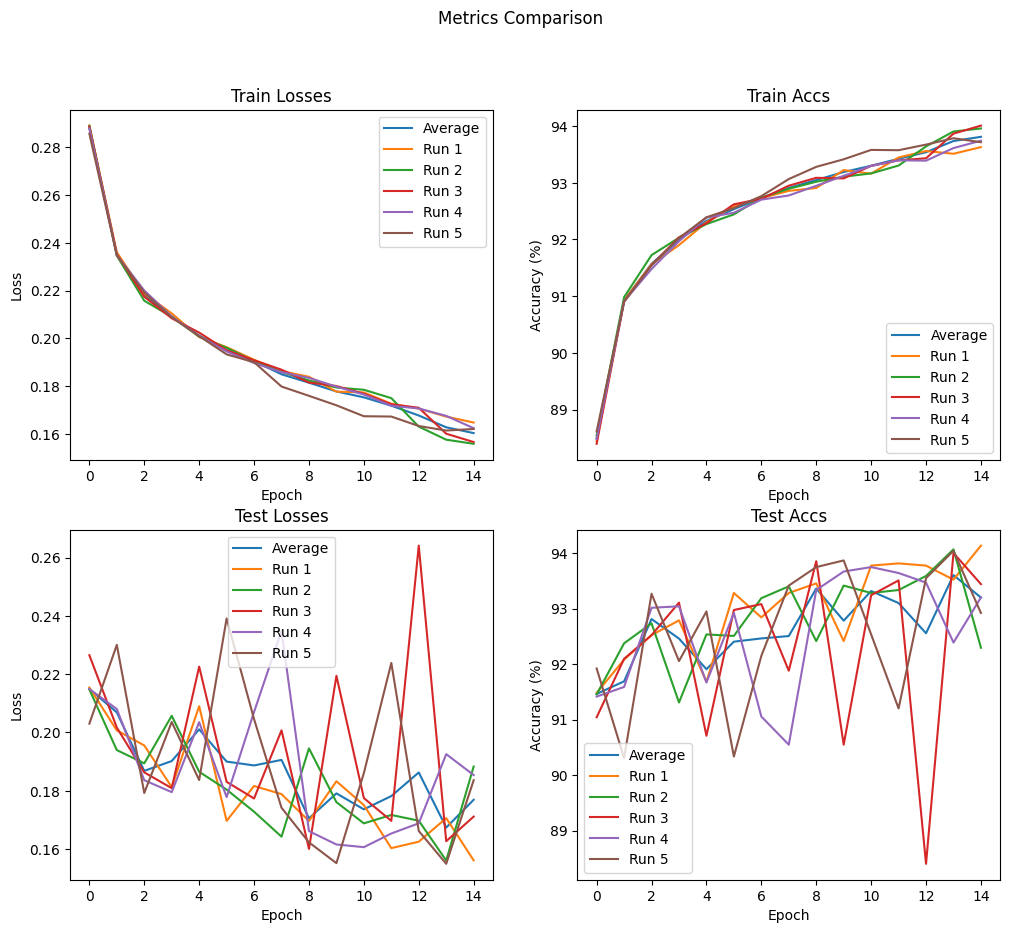

,Run,Epoch,Train Loss,Train Accuracy,Test Loss,Test Accuracy
0,Run 1,Epoch 1,0.288959,88.446667,0.215441,91.480000
1,Run 1,Epoch 2,0.236018,90.925556,0.200715,92.080000
2,Run 1,Epoch 3,0.218745,91.561111,0.195552,92.520000
3,Run 1,Epoch 4,0.210485,91.901111,0.181248,92.786667
4,Run 1,Epoch 5,0.200570,92.304444,0.209027,91.680000
...,...,...,...,...,...,...
85,Average,Epoch 11,0.175374,93.299556,0.173605,93.314667
86,Average,Epoch 12,0.171888,93.422444,0.178169,93.098667
87,Average,Epoch 13,0.167790,93.538222,0.186274,92.554667
88,Average,Epoch 14,0.162861,93.735111,0.167355,93.602667


,Run,Epoch,Train Loss,Train Accuracy,Test Loss,Test Accuracy
0,Run 1,Epoch 1,0.288959,88.446667,0.215441,91.480000
1,Run 1,Epoch 2,0.236018,90.925556,0.200715,92.080000
2,Run 1,Epoch 3,0.218745,91.561111,0.195552,92.520000
3,Run 1,Epoch 4,0.210485,91.901111,0.181248,92.786667
4,Run 1,Epoch 5,0.200570,92.304444,0.209027,91.680000
...,...,...,...,...,...,...
85,Average,Epoch 11,0.175374,93.299556,0.173605,93.314667
86,Average,Epoch 12,0.171888,93.422444,0.178169,93.098667
87,Average,Epoch 13,0.167790,93.538222,0.186274,92.554667
88,Average,Epoch 14,0.162861,93.735111,0.167355,93.602667


In [ ]:
# Function to plot individual runs as separate lines on the same set of subplots
def plot_individual_runs(all_metrics, title):
    for i, metrics in enumerate(all_metrics):
        plot_metrics(metrics, axes, f"Run {i+1} - {title}")

# Function to plot the metrics of all runs and their average on the same set of subplots
def plot_metrics_with_average(avg_metrics, all_metrics, title):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    # Plot the average metrics
    plot_metrics(avg_metrics, axes, f"Average - {title}", label="Average")

    # Plot individual runs
    for i, metrics in enumerate(all_metrics):
        plot_metrics(metrics, axes, f"Run {i+1} - {title}", label=f"Run {i+1}")

    fig.suptitle(title)
    plt.show()
    
# Function to plot the metrics of a single run or the average on the given axes
def plot_metrics(metrics, axes, title, label):
    keys = ['train_losses', 'train_accs', 'test_losses', 'test_accs']
    ylabels = ['Loss', 'Accuracy (%)', 'Loss', 'Accuracy (%)']

    for i, (key, ylabel) in enumerate(zip(keys, ylabels)):
        ax = axes[i]
        ax.plot(metrics[key], label=label)
        ax.set_title(key.replace('_', ' ').title())
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylabel)
        ax.legend()

# Plot the metrics of all runs and their average
plot_metrics_with_average(avg_metrics, all_metrics, 'Metrics Comparison')

# Function to create a table that displays the metrics for each run and their average
def display_metrics_table(avg_metrics, all_metrics):
    data = []
    columns = ["Run", "Epoch", "Train Loss", "Train Accuracy", "Test Loss", "Test Accuracy"]

    for run, metrics in enumerate(all_metrics):
        for epoch in range(len(metrics['train_losses'])):
            data.append([f"Run {run + 1}",
                         f"Epoch {epoch + 1}",
                         metrics['train_losses'][epoch],
                         metrics['train_accs'][epoch],
                         metrics['test_losses'][epoch],
                         metrics['test_accs'][epoch]])

    for epoch in range(len(avg_metrics['train_losses'])):
        data.append(["Average",
                     f"Epoch {epoch + 1}",
                     avg_metrics['train_losses'][epoch],
                     avg_metrics['train_accs'][epoch],
                     avg_metrics['test_losses'][epoch],
                     avg_metrics['test_accs'][epoch]])

    df = pd.DataFrame(data, columns=columns)
    display(df)

# Display the tabular representation of the metrics
display_metrics_table(avg_metrics, all_metrics)


# Display the tabular representation of the metrics
display_metrics_table(avg_metrics, all_metrics)


In [ ]:
# Create the "models" directory if it does not exist
os.makedirs("models", exist_ok=True)

# Save the best model in the "models" directory
torch.save(best_model.state_dict(), "models/best_model2.pth")

In [ ]:
# Load the best model
model = nnmodel.SymmetricNet2(0.5)
model.load_state_dict(torch.load("models/best_model.pth"))

# Set model to evaluation mode
model = model.to(device)  # Move the model to the appropriate device
model.eval()

# Evaluate the model on your data
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for inputs, labels in testLoader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the appropriate device
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 94.13%
